In [5]:
!kaggle datasets download -d kiva/data-science-for-good-kiva-crowdfunding --unzip

Dataset URL: https://www.kaggle.com/datasets/kiva/data-science-for-good-kiva-crowdfunding
License(s): CC0-1.0




  0%|          | 0.00/41.9M [00:00<?, ?B/s]
  2%|▏         | 1.00M/41.9M [00:00<00:30, 1.38MB/s]
  5%|▍         | 2.00M/41.9M [00:00<00:14, 2.79MB/s]
 10%|▉         | 4.00M/41.9M [00:01<00:07, 5.58MB/s]
 14%|█▍        | 6.00M/41.9M [00:01<00:04, 8.39MB/s]
 19%|█▉        | 8.00M/41.9M [00:01<00:03, 10.6MB/s]
 24%|██▍       | 10.0M/41.9M [00:01<00:02, 12.8MB/s]
 29%|██▊       | 12.0M/41.9M [00:01<00:02, 14.3MB/s]
 33%|███▎      | 14.0M/41.9M [00:01<00:01, 15.4MB/s]
 38%|███▊      | 16.0M/41.9M [00:01<00:01, 15.7MB/s]
 43%|████▎     | 18.0M/41.9M [00:01<00:01, 16.7MB/s]
 48%|████▊     | 20.0M/41.9M [00:02<00:01, 14.3MB/s]
 53%|█████▎    | 22.0M/41.9M [00:02<00:01, 12.3MB/s]
 57%|█████▋    | 24.0M/41.9M [00:02<00:01, 12.3MB/s]
 62%|██████▏   | 26.0M/41.9M [00:02<00:01, 12.8MB/s]
 67%|██████▋   | 28.0M/41.9M [00:02<00:01, 13.5MB/s]
 72%|███████▏  | 30.0M/41.9M [00:02<00:00, 14.0MB/s]
 76%|███████▋  | 32.0M/41.9M [00:02<00:00, 14.3MB/s]
 81%|████████  | 34.0M/41.9M [00:03<00:00, 13.5MB/s]
 

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import shap
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

In [7]:
data = pd.read_csv('kiva_loans.csv')

In [8]:
data.head()

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,NaN,female,irregular,2014-01-01
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,NaN,"female, female",irregular,2014-01-01
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another ...,IN,India,Maynaguri,INR,334.0,2014-01-01 09:58:07+00:00,2013-12-17 08:00:00+00:00,2014-01-01 16:01:36+00:00,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01
3,653063,200.0,200.0,Embroidery,Arts,to purchase an embroidery machine and a variet...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 08:03:11+00:00,2013-12-24 08:00:00+00:00,2014-01-01 13:00:00+00:00,11.0,8,NaN,female,irregular,2014-01-01
4,653084,400.0,400.0,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,PKR,245.0,2014-01-01 11:53:19+00:00,2013-12-17 08:00:00+00:00,2014-01-01 19:18:51+00:00,14.0,16,NaN,female,monthly,2014-01-01


In [9]:
data.shape

(671205, 20)

In [10]:
data.columns

Index(['id', 'funded_amount', 'loan_amount', 'activity', 'sector', 'use',
       'country_code', 'country', 'region', 'currency', 'partner_id',
       'posted_time', 'disbursed_time', 'funded_time', 'term_in_months',
       'lender_count', 'tags', 'borrower_genders', 'repayment_interval',
       'date'],
      dtype='object')

In [11]:
selected_features = ['sector','borrower_genders','loan_amount','term_in_months','country','lender_count']
df = data[selected_features]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671205 entries, 0 to 671204
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sector            671205 non-null  object 
 1   borrower_genders  666984 non-null  object 
 2   loan_amount       671205 non-null  float64
 3   term_in_months    671205 non-null  float64
 4   country           671205 non-null  object 
 5   lender_count      671205 non-null  int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 30.7+ MB


In [12]:
#missing small amount of genders in part of the dataset. I decide just to remove these rows. Could have imputed, but dont think it makes much sense
#given that is is gender. Also not a lot of rows of data in terms of the overall amount of data.

df = df.dropna(subset=['borrower_genders'])
#df = df.dropna(subset=['partner_id'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 666984 entries, 0 to 671204
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sector            666984 non-null  object 
 1   borrower_genders  666984 non-null  object 
 2   loan_amount       666984 non-null  float64
 3   term_in_months    666984 non-null  float64
 4   country           666984 non-null  object 
 5   lender_count      666984 non-null  int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 35.6+ MB


In [13]:
def gender_group(row):
    if row['borrower_genders'] == 'male':
        return 'male'
    elif row['borrower_genders'] == 'female':
        return 'female'
    else:
        return 'group'

# Apply the function and overwrite the 'borrower_genders' column
df['borrower_genders'] = df.apply(gender_group, axis=1)
df['borrower_genders'].value_counts()

borrower_genders
female    426502
male      134710
group     105772
Name: count, dtype: int64

In [14]:
df['country'].value_counts()

country
Philippines      160361
Kenya             75113
El Salvador       39321
Cambodia          34811
Pakistan          26853
                  ...  
Afghanistan           2
Guam                  1
Mauritania            1
Cote D'Ivoire         1
Bhutan                1
Name: count, Length: 87, dtype: int64

In [15]:
country_counts = df['country'].value_counts()
df = df[df['country'].isin(country_counts[country_counts >= 1000].index)]
df['country'].value_counts()

country
Philippines                             160361
Kenya                                    75113
El Salvador                              39321
Cambodia                                 34811
Pakistan                                 26853
Peru                                     22179
Colombia                                 21218
Uganda                                   20390
Tajikistan                               19518
Ecuador                                  13487
Paraguay                                 11841
Nicaragua                                11676
India                                    11194
Vietnam                                  10841
Nigeria                                  10130
Lebanon                                   8776
Bolivia                                   8732
Armenia                                   8628
Palestine                                 8152
Samoa                                     7372
Guatemala                                 7234
Rwand

In [16]:
# Separate features and target
X = df.drop('loan_amount', axis=1)
y = df['loan_amount']

# One-hot encode categorical variables
ohe = OneHotEncoder() # be careful - output is a sparse matrix
cat_features = ['sector','borrower_genders','country']
X_cat = pd.DataFrame(ohe.fit_transform(X[cat_features]).todense(), columns=ohe.get_feature_names_out(cat_features))

# Scale numerical features
scaler = StandardScaler()
num_features = ['term_in_months','lender_count']
X_num = pd.DataFrame(scaler.fit_transform(X[num_features]), columns=num_features)

# Combine encoded categorical and scaled numerical features
X_processed = pd.concat([X_num, X_cat], axis=1)

print("Shape of processed features:", X_processed.shape)

Shape of processed features: (657396, 74)


In [17]:
print("Unique values per categorical feature:")
for feature in cat_features:
    print(f"{feature}: {X[feature].nunique()}")


Unique values per categorical feature:
sector: 15
borrower_genders: 3
country: 54


In [18]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Train XGBoost model
model_xgb = XGBRegressor(random_state=42)
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [19]:
model_xgb.score(X_train, y_train)

0.8718927886756114

In [20]:
model_xgb.score(X_test, y_test)

0.808588953049119

In [ ]:
lin_reg

In [21]:
#scorer = make_scorer(mean_squared_error)

#xgb_param_grid = {
 #   'n_estimators': [100, 200, 300],
 #   'learning_rate': [0.01, 0.1, 0.2],
    #'max_depth': [3, 5, 7],
   # 'subsample': [0.7, 0.8, 1.0],
   # 'colsample_bytree': [0.7, 0.8, 1.0]
#}


#grid_obj = GridSearchCV(model_xgb, xgb_param_grid, scoring=scorer)


#grid_fit = grid_obj.fit(X_processed, y)

# Get the estimator.
#best_reg = grid_fit.best_estimator_

# Fit the new model.
#best_reg.fit(X_train, y_train)

# Model performance on TEST data
#best_reg.score(X_test, y_test)

In [22]:

train_rmse_xgb = np.sqrt(mean_squared_error(y_train, model_xgb.predict(X_train)))
test_rmse_xgb = np.sqrt(mean_squared_error(y_test, model_xgb.predict(X_test)))

print(f"Train RMSE XGBoost: {train_rmse_xgb:.2f}")
print(f"Test RMSE XGBoost: {test_rmse_xgb:.2f}")


Train RMSE XGBoost: 413.81
Test RMSE XGBoost: 520.61


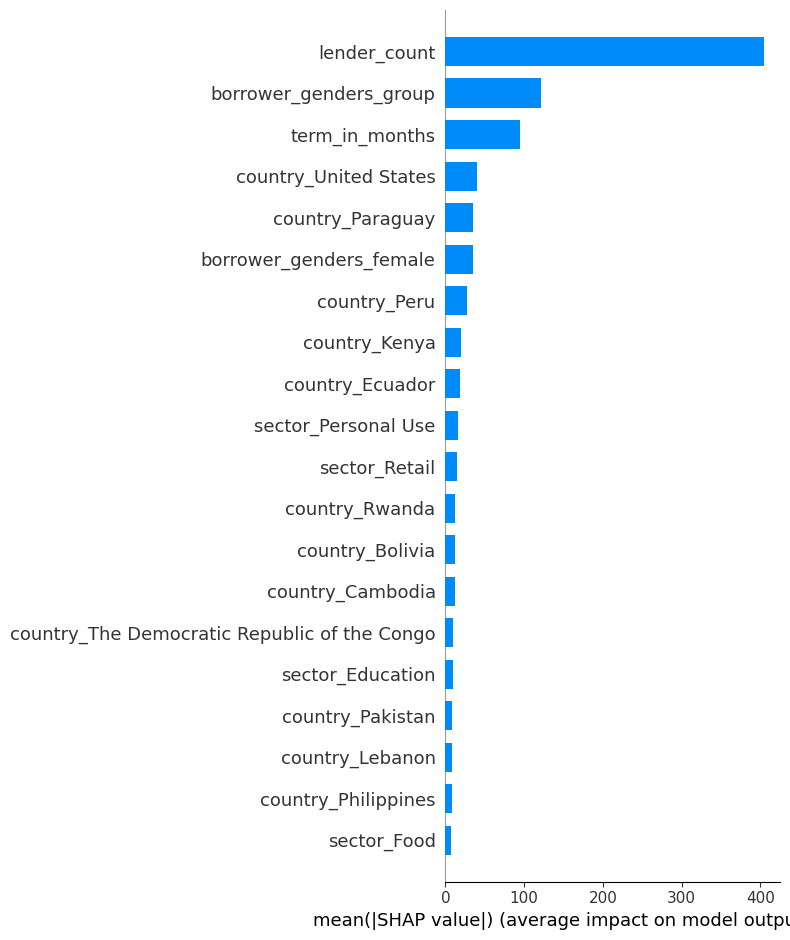

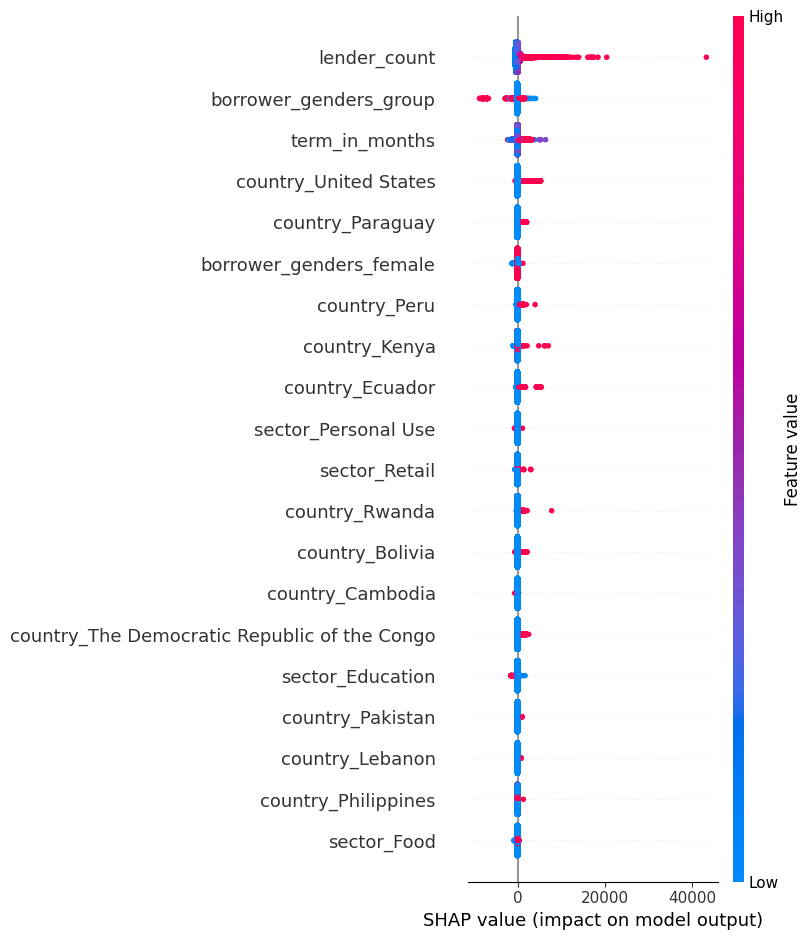

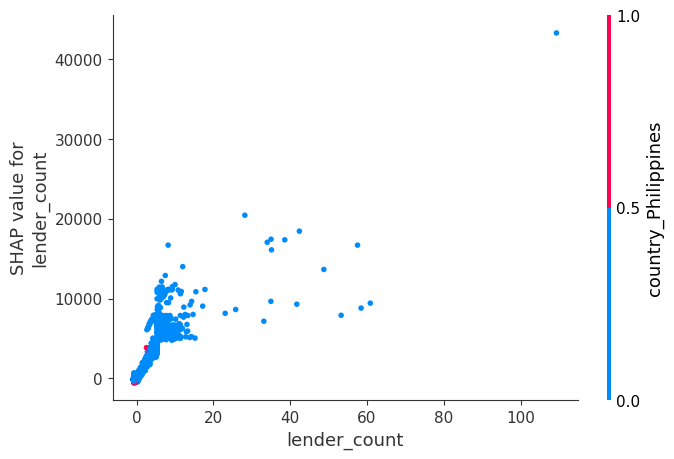

In [23]:
# Create a SHAP explainer
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test)

# Plot feature importances
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Plot SHAP values
shap.summary_plot(shap_values, X_test)

# Plot dependence for the most important feature
most_important_feature = X_test.columns[np.argmax(np.abs(shap_values).mean(0))]
shap.dependence_plot(most_important_feature, shap_values, X_test)

In [24]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1,:], X_test.iloc[1,:])

In [26]:
joblib.dump(model_xgb, 'model_xgb.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(ohe, 'ohe.joblib')

['ohe.joblib']